In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
plt.style.use("ggplot")
from ggplot import *
%matplotlib inline

## 2D Stencil Benchmark
only the partitioning scheme was set by hand

In [2]:
df = pd.read_csv("../victoria_2D_stencil_2016-07-07.csv")
df = df.groupby(["O3", "gpus", "N"]).mean()
df = df.reset_index()
df["GFLOPs"] = df.loc[:,["N", "usr_kernel_time"]].apply(lambda x: x[0]**2 * 7 * 1000 / x[1] / 1e9, axis=1)
df["key"] = df[["O3", "gpus", "N"]].apply(lambda x : "ngpus" + str(x[1]) + "-" + str(x[2]) + ("O3" if x[0] else ""), axis = 1)
df["dep_res_time"] = df[["dep_res_creation_time", "dep_res_exec_time", "gpus"]].apply(lambda x : 0 if x[2] == 1 else x[0] + x[1], axis=1)
df["ratio_depres_usrkernel"] = df[["dep_res_time", "usr_kernel_time"]].apply(lambda x : x[0] / x[1], axis=1)
df["ratio_depres_exec"] = df[["dep_res_time", "dep_res_exec_time"]].apply(lambda x : x[1] / x[0], axis=1)
df["kernel_speedup"] = df.loc[:,["N", "usr_kernel_time"]].apply(lambda x: df[df.gpus == 1][df.N == x[0]].loc[:,["usr_kernel_time"]].iloc[0,0] / x[1], axis=1)
df["total_time"] = df[["usr_htod_time", "usr_kernel_time", "usr_dtoh_time"]].apply(lambda x : x[0] + x[1] + x[2], axis=1)
df["total_speedup"] = df.loc[:,["N", "total_time"]].apply(lambda x: df[df.gpus == 1][df.N == x[0]].loc[:,["total_time"]].iloc[0,0] / x[1], axis=1)
df["kernel-depres"] = df[["dep_res_time", "usr_kernel_time"]].apply(lambda x : x[1] - x[0], axis=1)
#df = df.set_index(df["key"])
df.head()

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,O3,gpus,N,iter,usr_htod_time,usr_kernel_time,usr_dtoh_time,dep_res_creation_time,dep_res_exec_time,linearization_time,GFLOPs,key,dep_res_time,ratio_depres_usrkernel,ratio_depres_exec,kernel_speedup,total_time,total_speedup,kernel-depres
0,False,1,1024,3,0.002069,0.156810,0.001089,NaN,NaN,NaN,46.808384,ngpus1-1024,0,0,NaN,1,0.159969,1,0.156810
1,False,1,2048,3,0.009417,0.432228,0.004760,NaN,NaN,NaN,67.927440,ngpus1-2048,0,0,NaN,1,0.446405,1,0.432228
2,False,1,4096,3,0.029112,1.649292,0.015688,NaN,NaN,NaN,71.206622,ngpus1-4096,0,0,NaN,1,1.694091,1,1.649292
3,False,1,8192,3,0.130322,6.585502,0.078112,NaN,NaN,NaN,71.332762,ngpus1-8192,0,0,NaN,1,6.793936,1,6.585502
4,False,1,12288,3,0.300321,15.180620,0.159650,NaN,NaN,NaN,69.625918,ngpus1-12288,0,0,NaN,1,15.640590,1,15.180620


/usr/local/lib/python2.7/dist-packages/matplotlib-1.5.1_1670.gc03262a-py2.7-linux-x86_64.egg/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


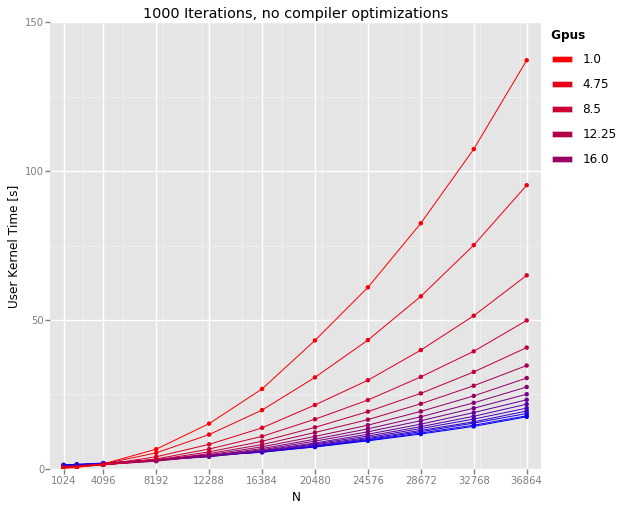

<ggplot: (8741212623241)>

In [3]:
df_kernel = df[df.O3 == False]
#df_kernel["key"] = df_kernel[["gpus", "O3"]].apply(lambda x : str(x[0]) + "-" + str(x[1]), axis = 1)
#df_kernel = df_kernel[["key", "usr_kernel_time"]]
#df_kernel = df_kernel.pivot(columns="key", values="usr_kernel_time")
#df_kernel.head()
#fig = plt.figure()
#ax0 = fig.add_subplot(111)
#for ngpus in range(1,17):
#    subdata = df_kernel[(df_kernel.gpus == ngpus) & (df_kernel.O3 == False)]
#    ax0.plot(subdata.index.values, subdata["usr_kernel_time"].values)

p = ggplot(aes(x="N", y="usr_kernel_time", color="gpus"), data=df_kernel) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("User Kernel Time [s]") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864])+\
xlim(0, 38000) + ylim(0, 150) + ggtitle("1000 Iterations, no compiler optimizations")
p


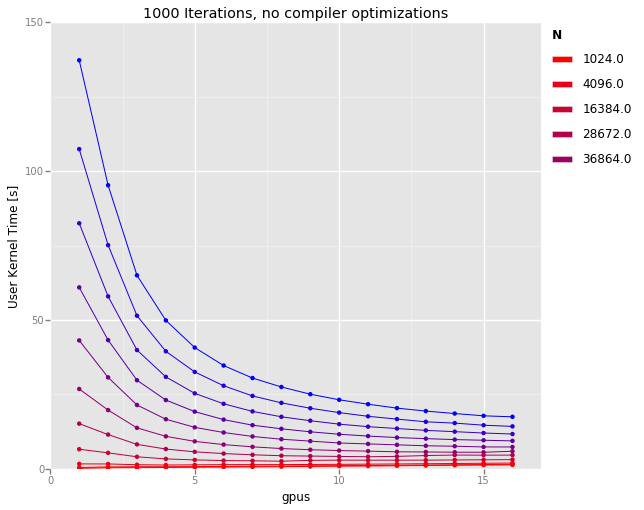

<ggplot: (8741212623153)>

In [4]:
p = ggplot(aes(x="gpus", y="usr_kernel_time", color="N"), data=df[df.O3 == False]) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("User Kernel Time [s]") +\
xlim(0, 17) + ylim(0, 150) + ggtitle("1000 Iterations, no compiler optimizations")
p


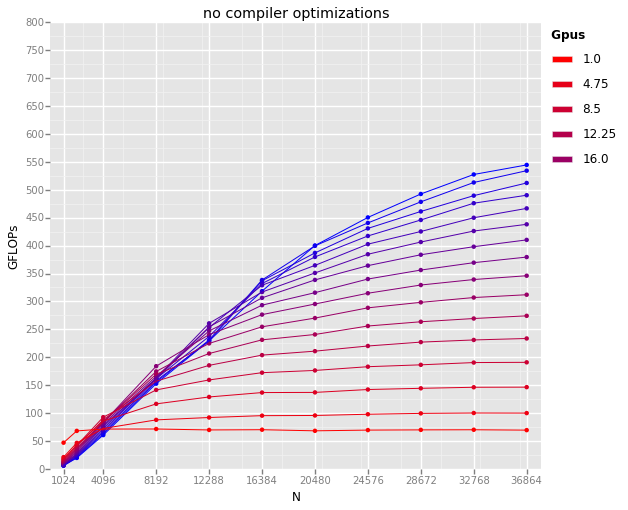

<ggplot: (8741212014945)>

In [5]:
p = ggplot(aes(x="N", y="GFLOPs", color="gpus"), data=df[df.O3 == False]) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("GFLOPs") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864]) +\
xlim(0, 38000) + ylim(0, 800) + ggtitle("no compiler optimizations")
p

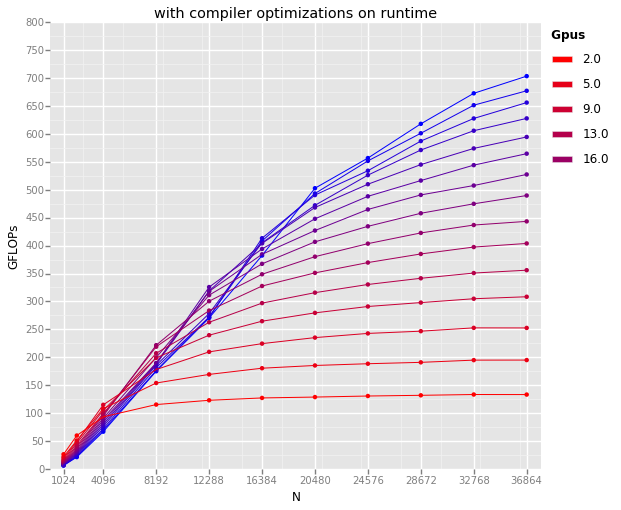

<ggplot: (8741212014953)>

In [6]:
p = ggplot(aes(x="N", y="GFLOPs", color="gpus"), data=df[df.O3 == True]) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("GFLOPs") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864]) +\
xlim(0, 38000) + ylim(0, 800) + ggtitle("with compiler optimizations on runtime")
p

Text(0.5,1,u"Performance of 2D Stencil Code\n(dotted lines represent Mekong's runtime compiled with -O3 flag)")

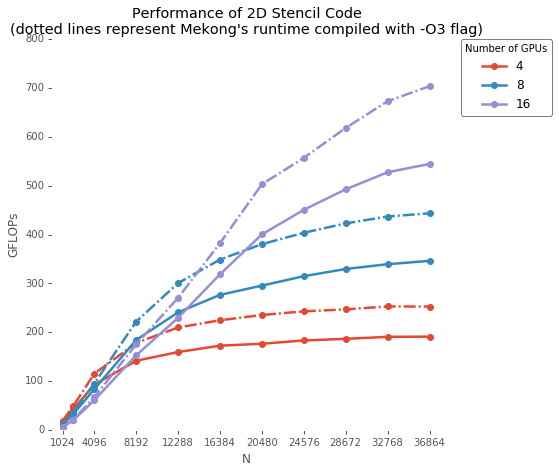

In [7]:
#sm = ScalarMappable()
#sm.set_clim(vmin = 1024, vmax = 36864)
#cmName = "viridis"
#sm.set_cmap(cmName)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
for gpus in [4, 8, 16]:
    not_opt_data = df[(df.O3 == False)][["N","GFLOPs"]][df.gpus == gpus]
    line = ax.plot(not_opt_data["N"].values, not_opt_data["GFLOPs"].values, label=gpus, marker='.', ms=12)
    c = line[0].get_color()
    opt_data = df[(df.O3 == True)][["N","GFLOPs"]][df.gpus == gpus]
    line = ax.plot(opt_data["N"].values, opt_data["GFLOPs"].values, marker='.', ms=12, c=c, ls="-.")

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Number of GPUs")
ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_ticks_position("left")
ax.set_xlim(0, 38000)
ax.set_ylim(0, 800)
ax.set_xticks([1024,4096,8192,12288,16384,20480,24576,28672,32768,36864])
ax.set_xlabel("N")
ax.set_ylabel("GFLOPs")
fig.subplots_adjust(right=0.8)
ax.set_title("Performance of 2D Stencil Code\n(dotted lines represent Mekong's runtime compiled with -O3 flag)")

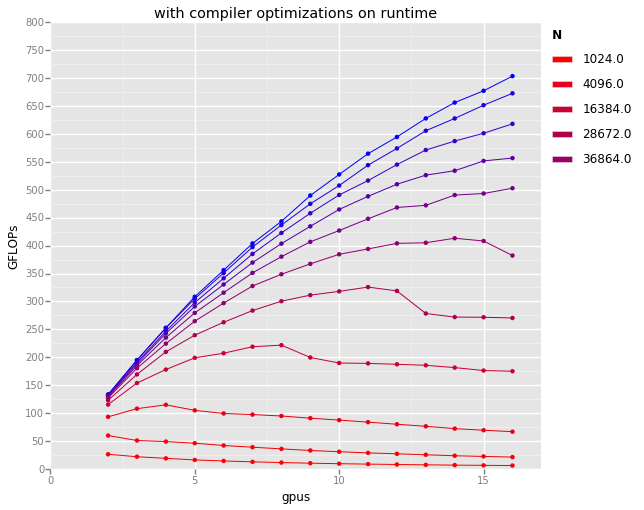

<ggplot: (8741211987717)>

In [8]:
p = ggplot(aes(x="gpus", y="GFLOPs", color="N"), data=df[df.O3 == True]) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("GFLOPs") +\
xlim(0, 17) + ylim(0, 800) + ggtitle("with compiler optimizations on runtime")
p

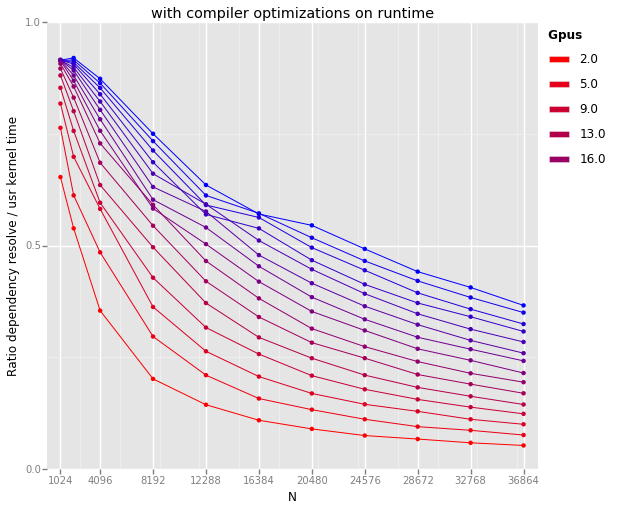

<ggplot: (8741211976273)>

In [9]:
p = ggplot(aes(x="N", y="ratio_depres_usrkernel", color="gpus"), data=df[df.O3 == True]) +\
geom_point(size=20) + geom_line() + ylab("Ratio dependency resolve / usr kernel time") +\
scale_color_gradient(low="red", high="blue") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864]) +\
xlim(0, 38000) + ylim(0, 1) + ggtitle("with compiler optimizations on runtime")
p

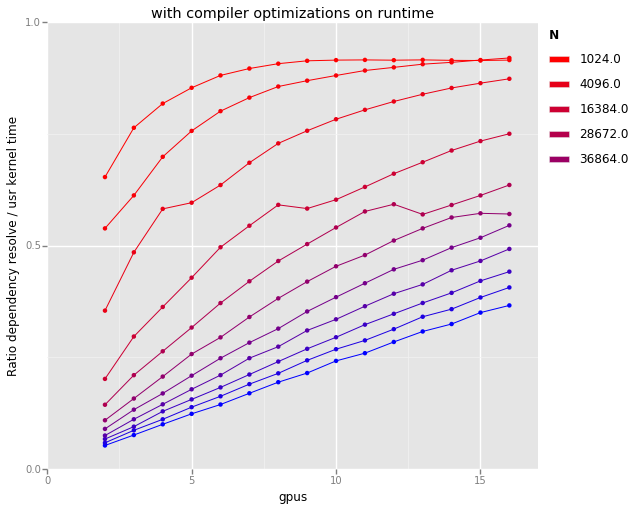

<ggplot: (8741211902101)>

In [10]:
p = ggplot(aes(x="gpus", y="ratio_depres_usrkernel", color="N"), data=df[df.O3 == True]) +\
geom_point(size=20) + geom_line() + ylab("Ratio dependency resolve / usr kernel time") +\
scale_color_gradient(low="red", high="blue") +\
xlim(0, 17) + ylim(0, 1) + ggtitle("with compiler optimizations on runtime")
p

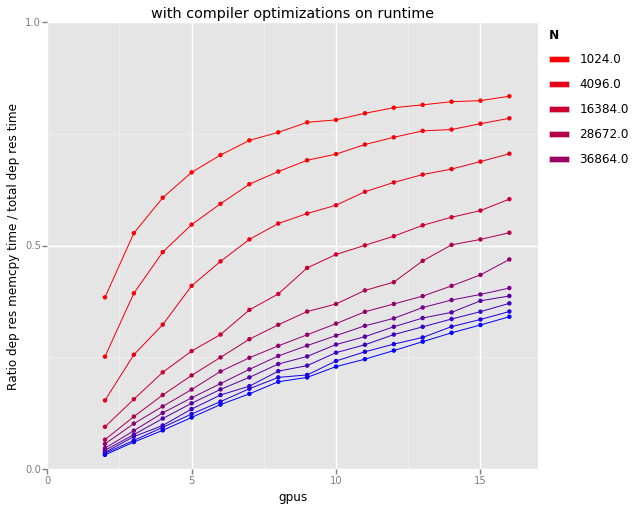

<ggplot: (8741211876549)>

In [11]:
p = ggplot(aes(x="gpus", y="ratio_depres_exec", color="N"), data=df[df.O3 == True]) +\
geom_point(size=20) + geom_line() + ylab("Ratio dep res memcpy time / total dep res time") +\
scale_color_gradient(low="red", high="blue") +\
xlim(0, 17) + ylim(0, 1) + ggtitle("with compiler optimizations on runtime")
p

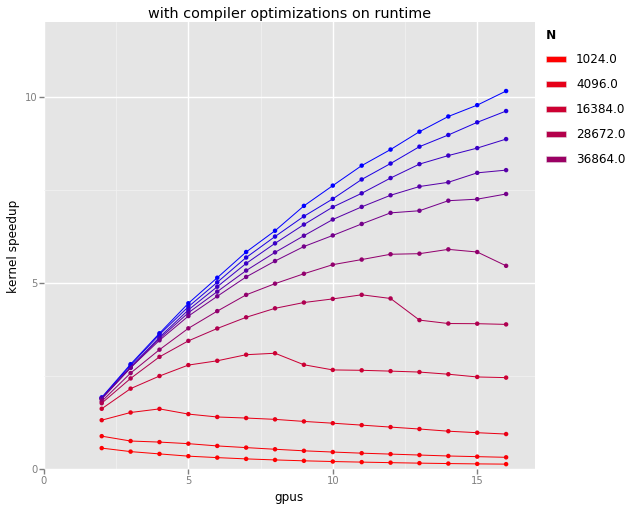

<ggplot: (8741211920605)>

In [12]:
p = ggplot(aes(x="gpus", y="kernel_speedup", color="N"), data=df[df.O3 == True]) +\
geom_point(size=20) + geom_line() + ylab("kernel speedup") +\
scale_color_gradient(low="red", high="blue") +\
xlim(0, 17) + ylim(0, 12) + ggtitle("with compiler optimizations on runtime")
p

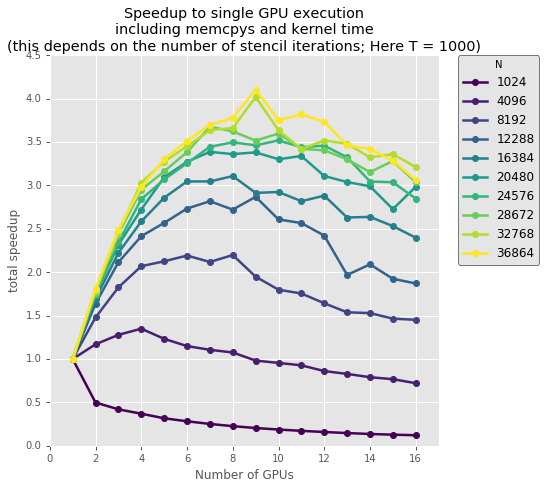

In [13]:
#p = ggplot(aes(x="gpus", y="total_speedup", color="N"), data=df[df.O3 == True]) +\
#geom_point(size=20) + geom_line() + ylab("total speedup") +\
#scale_color_gradient(low="red", high="blue") +\
#xlim(0, 17) + ylim(0, 5) + ggtitle("with compiler optimizations on runtime")
#p
plt.style.use("ggplot")
sm = ScalarMappable()
sm.set_clim(vmin = 1024, vmax = 36864)
cmName = "viridis"
sm.set_cmap(cmName)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
for N in [1024,4096,8192,12288,16384,20480,24576,28672,32768,36864]:
    su_data = df[(df.O3 == True) | (df.gpus == 1)]["total_speedup"][df.N == N]
    ax.plot(range(1,17), su_data, label=N, marker='.', ms=12, c=sm.to_rgba(N))

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="N")
ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_ticks_position("left")
ax.set_xlim(0, 17)
ax.set_ylim(0, 4.5)
ax.set_xlabel("Number of GPUs")
ax.set_ylabel("total speedup")
ax.set_title("Speedup to single GPU execution\nincluding memcpys and kernel time\n(this depends on the number of stencil iterations; Here T = 1000)")
fig.subplots_adjust(right=0.8)

Creating two barplots...


Text(0.5,0.98,u'2D Stencil Code')

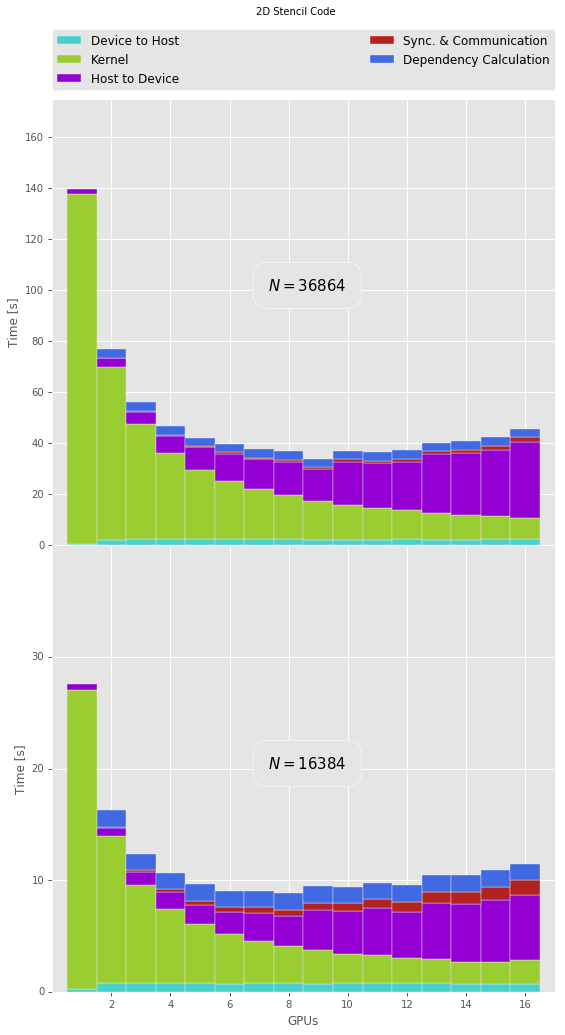

In [14]:
plt.style.use("ggplot")
dummy = df[(df.N == 36864) & ((df.O3 == True) | (df.gpus == 1))].loc[:,["gpus","usr_dtoh_time","usr_htod_time", "kernel-depres","dep_res_exec_time", "dep_res_creation_time"]]
dummy.columns = ["GPUs", "Device to Host", "Host to Device", "Kernel", "Communication", "Dependency Calculation"]

sm = ScalarMappable()
sm.set_clim(vmin = 0, vmax = 4)
cmName = "viridis"
sm.set_cmap(cmName)
width = 1
lw = 0.4
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(211)

#colors = ["seagreen", "brown", "darkorange", "indigo"]
colors = ["yellowgreen", "darkviolet", "mediumturquoise", "firebrick", "royalblue"]

##### FIRST BARPLOT
print "Creating two barplots..."

ax.bar(range(1,17), dummy["Device to Host"].values, align="center", width=width,\
      label="Device to Host", linewidth=lw, color=colors[2])
cumu = dummy["Device to Host"].values
ax.bar(range(1,17), dummy["Kernel"].values, width = width, align="center",\
       label="Kernel", linewidth=lw, color=colors[0], bottom=cumu)
cumu += dummy["Kernel"].values
ax.bar(range(1,17), dummy["Host to Device"].values, align="center", width=width,\
       label="Host to Device", bottom = cumu, linewidth=lw, color=colors[1])
cumu += dummy["Host to Device"].values
ax.bar(range(1,17), dummy["Communication"].values, align="center", width=width,\
       label="Sync. & Communication", bottom = cumu, linewidth=lw, color=colors[3])
cumu += dummy["Communication"]
ax.bar(range(1,17), dummy["Dependency Calculation"].values, align="center", width=width,\
       label="Dependency Calculation", bottom = cumu, linewidth=lw, color=colors[4])

ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_ticks_position("left")

ax.set_xlim(0,17)
ax.set_ylim(0, 175)
ax.set_ylabel("Time [s]")
ax.set_xticks(range(2,17,2))
ax.text(7.3, 100, "$N=36864$", fontsize=15, bbox={"facecolor":ax.get_facecolor(), "edgecolor":"white", "pad":1, "boxstyle":"round"})

#### SECOND BARPLOT

dummy = df[(df.N == 16384) & ((df.O3 == True) | (df.gpus == 1))].loc[:,["gpus","usr_dtoh_time","usr_htod_time", "kernel-depres","dep_res_exec_time", "dep_res_creation_time"]]
dummy.columns = ["GPUs", "Device to Host", "Host to Device", "Kernel", "Communication", "Dependency Calculation"]

ax1 = fig.add_subplot(212)

ax1.bar(range(1,17), dummy["Device to Host"].values, align="center", width=width,\
      label="Device to Host", linewidth=lw, color=colors[2])
cumu = dummy["Device to Host"].values
ax1.bar(range(1,17), dummy["Kernel"].values, width = width, align="center",\
       label="Kernel", linewidth=lw, color=colors[0], bottom=cumu)
cumu += dummy["Kernel"].values
ax1.bar(range(1,17), dummy["Host to Device"].values, align="center", width=width,\
       label="Host to Device", bottom = cumu, linewidth=lw, color=colors[1])
cumu += dummy["Host to Device"].values
ax1.bar(range(1,17), dummy["Communication"].values, align="center", width=width,\
       label="Sync. & Communication", bottom = cumu, linewidth=lw, color=colors[3])
cumu += dummy["Communication"]
ax1.bar(range(1,17), dummy["Dependency Calculation"].values, align="center", width=width,\
       label="Dependency Calculation", bottom = cumu, linewidth=lw, color=colors[4])

ax1.get_xaxis().set_ticks_position("bottom")
ax1.get_yaxis().set_ticks_position("left")
ax1.grid(which="minor")
ax1.set_xlim(0,17)
ax1.set_ylim(0, 40)
ax1.set_yticks(range(0,40,10))
ax1.set_ylabel("Time [s]")
ax1.set_xlabel("GPUs")
ax1.set_xticks(range(2,17,2))

ax1.text(7.3, 20, "$N=16384$", fontsize=15, bbox={"facecolor":ax1.get_facecolor(),"boxstyle":"round", "edgecolor":"white", "pad":1})

##### BACKGROUND IMAGE
legend = ax.legend(bbox_to_anchor=(0,1.02,1,0.102), loc=3, ncol=2, mode="expand",borderaxespad=0)
legend.get_frame().set_edgecolor("white")

#plotlim = ax.get_xlim() + ax.get_ylim()
#ax.imshow([[1, 1], [0, 0]], cmap=plt.cm.Greys,vmin= -0.5, vmax= 4, interpolation="bicubic", extent=plotlim, aspect="auto")
#plotlim = ax1.get_xlim() + ax1.get_ylim()
#ax1.imshow([[1, 1], [0, 0]], cmap=plt.cm.Greys,vmin= -0.5, vmax= 4, interpolation="bicubic", extent=plotlim, aspect="auto")

fig.subplots_adjust(hspace=0,top=0.9)#, right=0.85)
fig.suptitle("2D Stencil Code")

### Time for Dependency Resolution Creation

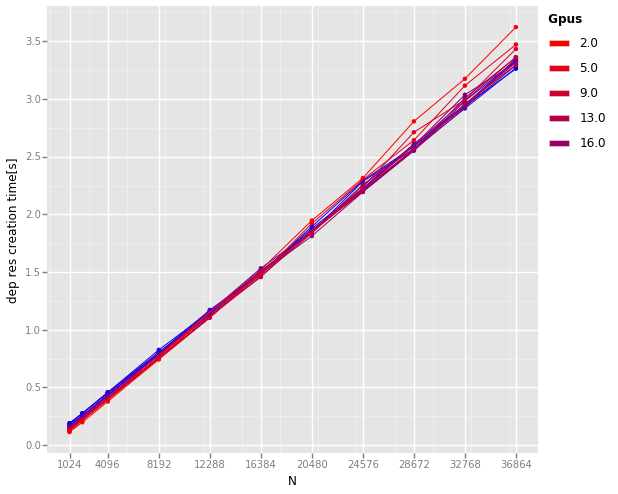

<ggplot: (8741212578081)>

In [15]:
p = ggplot(aes(x="N", y="dep_res_creation_time", color="gpus"), data=df[df.O3 == True]) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("dep res creation time[s]") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864])
#xlim(0, 38000) + ylim(0, 800)
p

### Time for Dependency Resolution Execution

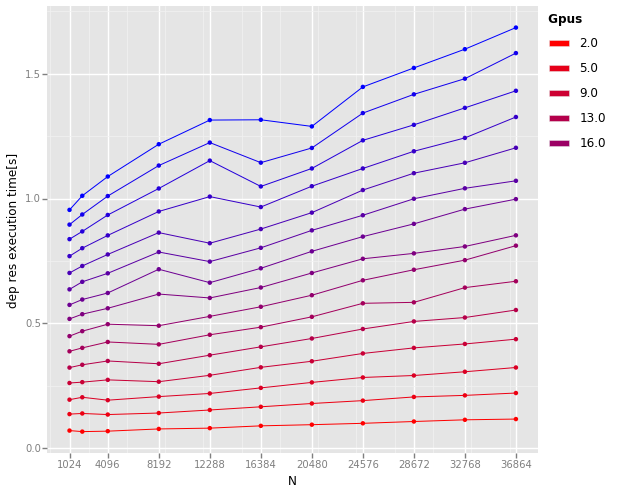

<ggplot: (8741210922593)>

In [16]:
p = ggplot(aes(x="N", y="dep_res_exec_time", color="gpus"), data=df[df.O3 == True]) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("dep res execution time[s]") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864])
#xlim(0, 38000) + ylim(0, 800)
p

## 2D Stencil Revisited with optimized Runtime

The crucial part in the above benchmark was the linearization of the accessed indices.
The following measurement was done with that part parallelized on host side.

In [2]:
df_old = pd.read_csv("../victoria_2D_stencil_2016-07-07.csv")
df_old = df_old.groupby(["O3", "gpus", "N"]).mean()

#df_old = dfr.groupby(["O3", "gpus", "N"]).mean()
dfr = pd.read_csv("../victoria_2D_stencil_2016-07-14.csv")
dfr = dfr.groupby(["O3", "gpus", "N"]).mean()
# Here we add all rows to dfr, which are not in dfr but in df_old
dfr = dfr.combine_first(df_old)
df_additional = df_old["dep_res_creation_time"]
df_additional.name = "old_dep_res_creation_time"
dfr = pd.concat([dfr, df_additional], axis=1, join="inner")
df_additional = df_old["dep_res_exec_time"]
df_additional.name = "old_dep_res_exec_time"
dfr = pd.concat([dfr, df_additional], axis=1, join="inner")
#dfr = pd.concat([dfr, df_old], axis=0, join="inner")
dfr = dfr.reset_index()
dfr["dep_res_creation_su"] = dfr.loc[:,["dep_res_creation_time", "old_dep_res_creation_time"]].apply(lambda x: x[1] / x[0], axis=1)
dfr["dep_res_time"] = dfr[["dep_res_creation_time", "dep_res_exec_time", "gpus"]].apply(lambda x : 0 if x[2] == 1 else x[0] + x[1], axis=1)
dfr["ratio_depres_usrkernel"] = dfr[["dep_res_time", "usr_kernel_time"]].apply(lambda x : x[0] / x[1], axis=1)
dfr["ratio_depres_exec"] = dfr[["dep_res_time", "dep_res_exec_time"]].apply(lambda x : x[1] / x[0], axis=1)
#dfr["kernel_speedup"] = dfr.loc[:,["N", "usr_kernel_time"]].apply(lambda x: dfr[dfr.gpus == 1][dfr.N == x[0]].loc[:,["usr_kernel_time"]].iloc[0,0] / x[1], axis=1)
dfr["total_time"] = dfr[["usr_htod_time", "usr_kernel_time", "usr_dtoh_time"]].apply(lambda x : x[0] + x[1] + x[2], axis=1)
dfr["total_speedup"] = dfr.loc[:,["N", "total_time"]].apply(lambda x: dfr[dfr.gpus == 1][dfr.N == x[0]].loc[:,["total_time"]].iloc[0,0] / x[1], axis=1)
dfr["kernel-depres"] = dfr[["dep_res_time", "usr_kernel_time"]].apply(lambda x : x[1] - x[0], axis=1)
dfr["dep_res_exec_rel_diff"] = dfr[["dep_res_exec_time", "old_dep_res_exec_time"]].apply(lambda x: abs(x[0] - x[1]) / x[1], axis=1)
dfr["rel_dep_res_creation_time"] = dfr[["total_time", "dep_res_creation_time"]].apply(lambda x: x[1]/x[0], axis=1)
dfr = dfr[(dfr.O3 == True) | (dfr.gpus == 1)]
dfr[(dfr.gpus == 2)].head(10)



/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,O3,gpus,N,iter,usr_htod_time,usr_kernel_time,usr_dtoh_time,dep_res_creation_time,dep_res_exec_time,linearization_time,...,old_dep_res_exec_time,dep_res_creation_su,dep_res_time,ratio_depres_usrkernel,ratio_depres_exec,total_time,total_speedup,kernel-depres,dep_res_exec_rel_diff,rel_dep_res_creation_time
176,True,2,1024,2,0.003106,0.207840,0.013534,0.036038,0.067363,0.032001,...,0.070789,3.149954,0.103401,0.497502,0.651475,0.224480,0.712619,0.104439,0.048404,0.160539
177,True,2,2048,2,0.012863,0.401662,0.026941,0.059022,0.064347,0.054895,...,0.066689,3.365523,0.123369,0.307146,0.521581,0.441466,1.011188,0.278293,0.035122,0.133695
178,True,2,4096,2,0.043131,1.009710,0.062248,0.103564,0.066086,0.098718,...,0.068495,3.655314,0.169650,0.168019,0.389543,1.115089,1.519243,0.840059,0.035164,0.092875
179,True,2,8192,2,0.171847,3.553570,0.147475,0.194559,0.071845,0.190228,...,0.077368,3.826755,0.266404,0.074968,0.269685,3.872892,1.754228,3.287166,0.071383,0.050236
180,True,2,12288,2,0.497185,7.985227,0.300193,0.300222,0.078975,0.295699,...,0.080593,3.845324,0.379198,0.047487,0.208270,8.782605,1.780860,7.606029,0.020071,0.034184
181,True,2,16384,2,0.924667,13.844500,0.482875,0.380920,0.084444,0.376259,...,0.089771,3.988171,0.465364,0.033614,0.181457,15.252042,1.806075,13.379136,0.059340,0.024975
182,True,2,20480,2,1.085657,22.037067,0.587783,0.498635,0.088596,0.493782,...,0.094435,3.903959,0.587232,0.026647,0.150871,23.710506,1.860096,21.449835,0.061827,0.021030
183,True,2,24576,2,1.575690,31.032500,0.843935,0.590615,0.093155,0.585876,...,0.099920,3.918266,0.683770,0.022034,0.136237,33.452125,1.865912,30.348730,0.067706,0.017656
184,True,2,28672,2,2.768703,41.955300,0.997213,0.707903,0.098227,0.702223,...,0.107158,3.963726,0.806129,0.019214,0.121850,45.721217,1.842313,41.149171,0.083352,0.015483
185,True,2,32768,2,3.390097,54.506767,1.421283,0.814283,0.105088,0.809050,...,0.113987,3.898853,0.919371,0.016867,0.114305,59.318147,1.849067,53.587395,0.078071,0.013727


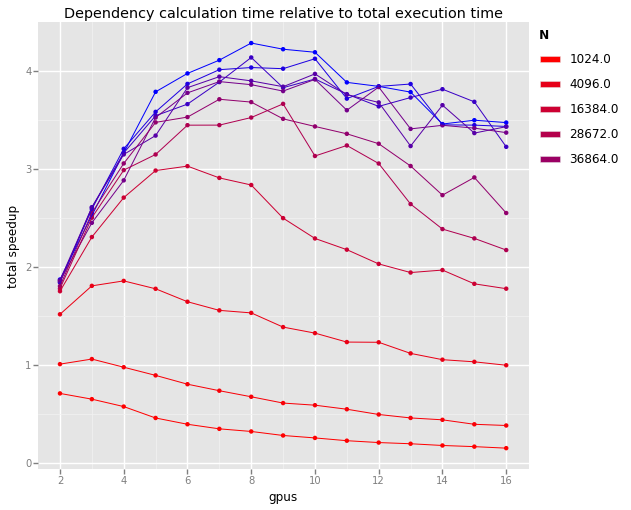

<ggplot: (8738630219453)>

In [4]:
p = ggplot(aes(x="gpus", y="total_speedup", color="N"), data=dfr[dfr.O3 == True]) +\
geom_point(size=20) + geom_line() + ggtitle("Dependency calculation time relative to total execution time") +\
scale_color_gradient(low="red", high="blue") + ylab("total speedup")
#scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864])
#xlim(0, 38000) + ylim(0, 800)
p

In [18]:
# SANDBOX
df0 = pd.read_csv("../victoria_2D_stencil_2016-07-07.csv")
df0 = df0[(df0.N < 2050) & (df0.gpus < 3)]
df0 = df0.groupby(["O3", "gpus", "N"]).mean()


#df_old = dfr.groupby(["O3", "gpus", "N"]).mean()
df1 = pd.read_csv("../victoria_2D_stencil_2016-07-14.csv")
df1 = df1[(df1.N < 4000) & (df1.gpus < 3) ]
df1 = df1.groupby(["O3", "gpus", "N"]).mean()

df0 = df0[["usr_htod_time", "usr_kernel_time", "dep_res_exec_time"]]
df1 = df1[["usr_htod_time", "usr_kernel_time", "dep_res_exec_time"]]

df0

usr_htod_time  usr_kernel_time  dep_res_exec_time
O3    gpus N                                                      
False 1    1024       0.002069         0.156810                NaN
           2048       0.009417         0.432228                NaN
      2    1024       0.003349         0.350576           0.075684
           2048       0.011247         0.632340           0.073586
True  2    1024       0.003681         0.282007           0.070789
           2048       0.010835         0.492654           0.066689

In [19]:
# SANDBOX
df1

usr_htod_time  usr_kernel_time  dep_res_exec_time
O3   gpus N                                                      
True 2    1024       0.003106         0.207840           0.067363
          2048       0.012863         0.401662           0.064347

In [20]:
# SANDBOX
#df1 = df1.reset_index()
#df0 = df0.reset_index()
df1.combine_first(df0)

usr_htod_time  usr_kernel_time  dep_res_exec_time
O3    gpus N                                                      
False 1    1024       0.002069         0.156810                NaN
           2048       0.009417         0.432228                NaN
      2    1024       0.003349         0.350576           0.075684
           2048       0.011247         0.632340           0.073586
True  2    1024       0.003106         0.207840           0.067363
           2048       0.012863         0.401662           0.064347

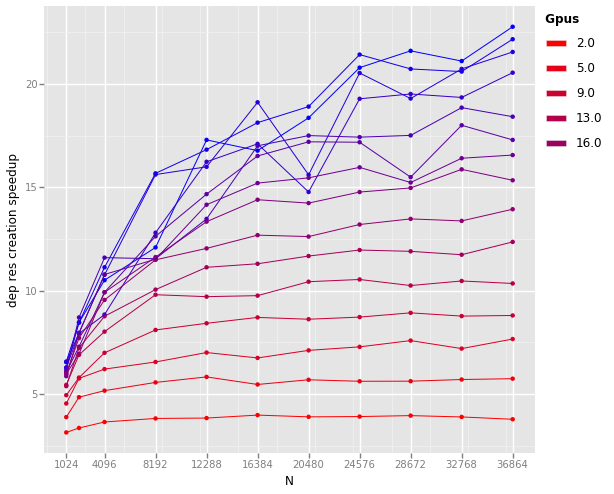

<ggplot: (8741210868281)>

In [21]:
p = ggplot(aes(x="N", y="dep_res_creation_su", color="gpus"), data=dfr[dfr.gpus > 1]) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("dep res creation speedup") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864])
xlim(0, 38000) + ylim(0, 25)
p

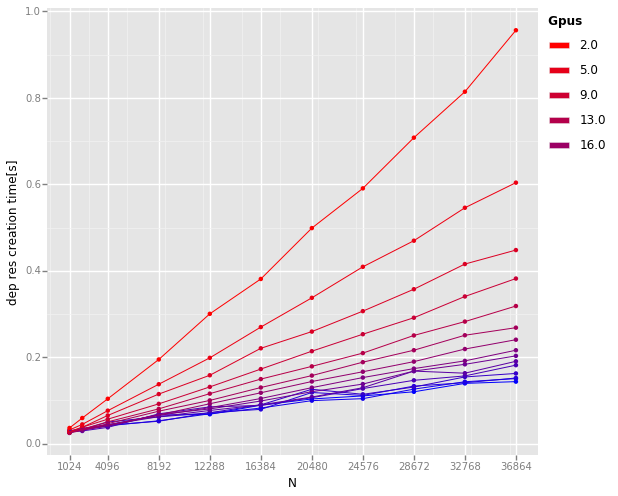

<ggplot: (8741210758313)>

In [22]:
p = ggplot(aes(x="N", y="dep_res_creation_time", color="gpus"), data=dfr[dfr.O3 == True]) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("dep res creation time[s]") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864])
#xlim(0, 38000) + ylim(0, 800)
p

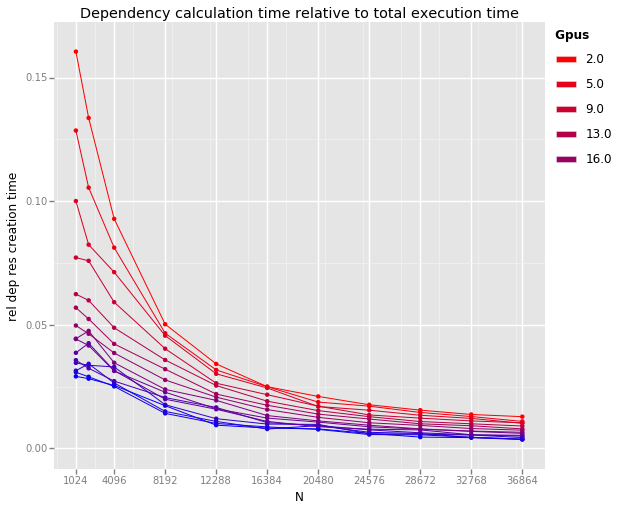

<ggplot: (8741210995901)>

In [23]:
p = ggplot(aes(x="N", y="rel_dep_res_creation_time", color="gpus"), data=dfr[dfr.O3 == True]) +\
geom_point(size=20) + geom_line() + ggtitle("Dependency calculation time relative to total execution time") +\
scale_color_gradient(low="red", high="blue") + ylab("rel dep res creation time") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864])
#xlim(0, 38000) + ylim(0, 800)
p

Creating two barplots...


Text(0.5,0.98,u'2D Stencil Code with optimized runtime')

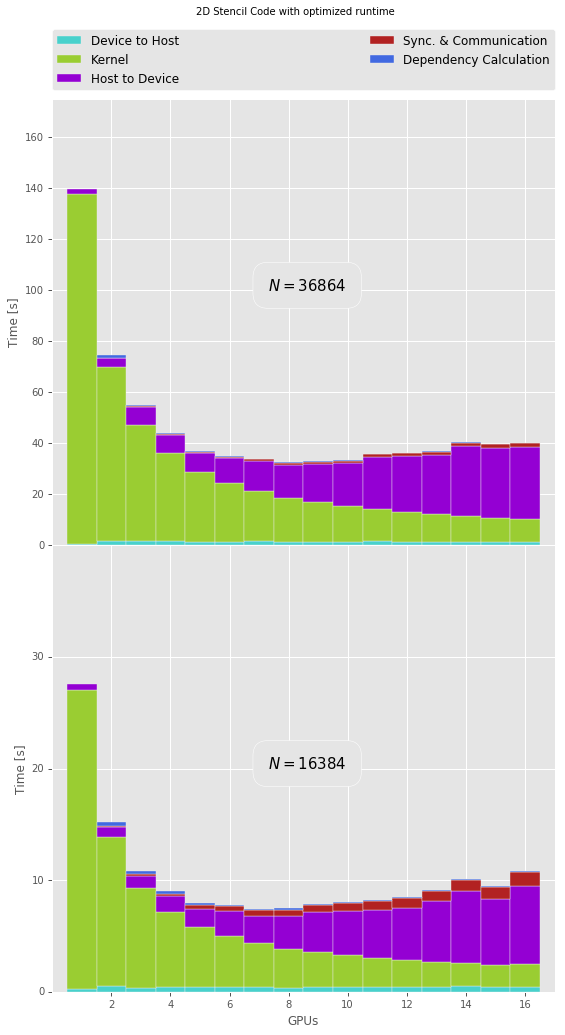

In [24]:
plt.style.use("ggplot")
dummy = dfr[(dfr.N == 36864) & ((dfr.O3 == True) | (dfr.gpus == 1))].loc[:,["gpus","usr_dtoh_time","usr_htod_time", "kernel-depres","dep_res_exec_time", "dep_res_creation_time"]]
dummy.columns = ["GPUs", "Device to Host", "Host to Device", "Kernel", "Communication", "Dependency Calculation"]

sm = ScalarMappable()
sm.set_clim(vmin = 0, vmax = 4)
cmName = "viridis"
sm.set_cmap(cmName)
width = 1
lw = 0.4
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(211)

#colors = ["seagreen", "brown", "darkorange", "indigo"]
colors = ["yellowgreen", "darkviolet", "mediumturquoise", "firebrick", "royalblue"]

##### FIRST BARPLOT
print "Creating two barplots..."

ax.bar(range(1,17), dummy["Device to Host"].values, align="center", width=width,\
      label="Device to Host", linewidth=lw, color=colors[2])
cumu = dummy["Device to Host"].values
ax.bar(range(1,17), dummy["Kernel"].values, width = width, align="center",\
       label="Kernel", linewidth=lw, color=colors[0], bottom=cumu)
cumu += dummy["Kernel"].values
ax.bar(range(1,17), dummy["Host to Device"].values, align="center", width=width,\
       label="Host to Device", bottom = cumu, linewidth=lw, color=colors[1])
cumu += dummy["Host to Device"].values
ax.bar(range(1,17), dummy["Communication"].values, align="center", width=width,\
       label="Sync. & Communication", bottom = cumu, linewidth=lw, color=colors[3])
cumu += dummy["Communication"]
ax.bar(range(1,17), dummy["Dependency Calculation"].values, align="center", width=width,\
       label="Dependency Calculation", bottom = cumu, linewidth=lw, color=colors[4])

ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_ticks_position("left")

ax.set_xlim(0,17)
ax.set_ylim(0, 175)
ax.set_ylabel("Time [s]")
ax.set_xticks(range(2,17,2))
ax.text(7.3, 100, "$N=36864$", fontsize=15, bbox={"facecolor":ax.get_facecolor(), "edgecolor":"white", "pad":1, "boxstyle":"round"})

#### SECOND BARPLOT

dummy = dfr[(dfr.N == 16384) & ((dfr.O3 == True) | (dfr.gpus == 1))].loc[:,["gpus","usr_dtoh_time","usr_htod_time", "kernel-depres","dep_res_exec_time", "dep_res_creation_time"]]
dummy.columns = ["GPUs", "Device to Host", "Host to Device", "Kernel", "Communication", "Dependency Calculation"]

ax1 = fig.add_subplot(212)

ax1.bar(range(1,17), dummy["Device to Host"].values, align="center", width=width,\
      label="Device to Host", linewidth=lw, color=colors[2])
cumu = dummy["Device to Host"].values
ax1.bar(range(1,17), dummy["Kernel"].values, width = width, align="center",\
       label="Kernel", linewidth=lw, color=colors[0], bottom=cumu)
cumu += dummy["Kernel"].values
ax1.bar(range(1,17), dummy["Host to Device"].values, align="center", width=width,\
       label="Host to Device", bottom = cumu, linewidth=lw, color=colors[1])
cumu += dummy["Host to Device"].values
ax1.bar(range(1,17), dummy["Communication"].values, align="center", width=width,\
       label="Sync. & Communication", bottom = cumu, linewidth=lw, color=colors[3])
cumu += dummy["Communication"]
ax1.bar(range(1,17), dummy["Dependency Calculation"].values, align="center", width=width,\
       label="Dependency Calculation", bottom = cumu, linewidth=lw, color=colors[4])

ax1.get_xaxis().set_ticks_position("bottom")
ax1.get_yaxis().set_ticks_position("left")
ax1.grid(which="minor")
ax1.set_xlim(0,17)
ax1.set_ylim(0, 40)
ax1.set_yticks(range(0,40,10))
ax1.set_ylabel("Time [s]")
ax1.set_xlabel("GPUs")
ax1.set_xticks(range(2,17,2))

ax1.text(7.3, 20, "$N=16384$", fontsize=15, bbox={"facecolor":ax1.get_facecolor(),"boxstyle":"round", "edgecolor":"white", "pad":1})

##### BACKGROUND IMAGE
legend = ax.legend(bbox_to_anchor=(0,1.02,1,0.102), loc=3, ncol=2, mode="expand",borderaxespad=0)
legend.get_frame().set_edgecolor("white")

#plotlim = ax.get_xlim() + ax.get_ylim()
#ax.imshow([[1, 1], [0, 0]], cmap=plt.cm.Greys,vmin= -0.5, vmax= 4, interpolation="bicubic", extent=plotlim, aspect="auto")
#plotlim = ax1.get_xlim() + ax1.get_ylim()
#ax1.imshow([[1, 1], [0, 0]], cmap=plt.cm.Greys,vmin= -0.5, vmax= 4, interpolation="bicubic", extent=plotlim, aspect="auto")

fig.subplots_adjust(hspace=0,top=0.9)#, right=0.85)
fig.suptitle("2D Stencil Code with optimized runtime")

### Difference in Sync. and Communication Time
The latter bar plot shows a smaller communication and synchronization time than
the bar plot of the not optimized runtime measurement. This should not be the case
and we want to evaluate if the difference in measured time is not only due to
statistical fluctuations.


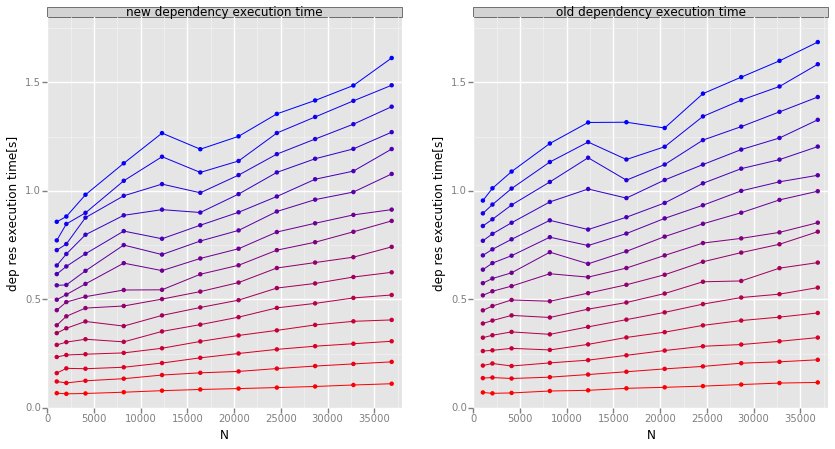

In [25]:
dfA= dfr[["gpus","N","old_dep_res_exec_time"]]
dfB = dfr[["gpus","N","dep_res_exec_time"]]
dfA.columns = ["gpus", "N", "old dependency execution time"]
dfB.columns = ["gpus", "N", "new dependency execution time"]
merged_df = pd.merge(dfA, dfB, on=["gpus", "N"])

merged_df = merged_df[merged_df.gpus > 1]
merged_df = pd.melt(merged_df, id_vars=["gpus", "N"], value_vars=["old dependency execution time", "new dependency execution time"])
merged_df.head()
p = ggplot(aes(x="N", y="value", color="gpus"), data=merged_df) +\
geom_point(size=20) + geom_line() + facet_wrap("variable", ncol=2) +\
scale_color_gradient(low="red", high="blue") + ylab("dep res execution time[s]") +\
xlim(0, 38000) + ylim(0, 1.8)

#scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864]) +\
p.draw()
fig = plt.gcf()
fig = fig.set_size_inches(14,7)



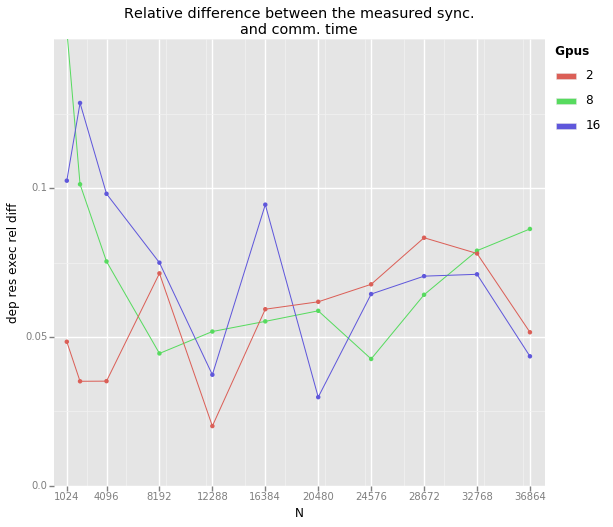

<ggplot: (8741205244477)>

In [26]:
p = ggplot(aes(x="N", y="dep_res_exec_rel_diff", color="gpus"), data=dfr[(dfr.gpus == 2) | (dfr.gpus == 8) | (dfr.gpus == 16)]) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("dep res exec rel diff") +\
xlim(0, 38000) + ylim(0, 0.15) + ggtitle("Relative difference between the measured sync.\nand comm. time") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864])
p

## 1D Stencil Benchmark

Kernel analysis was done by hand

In [27]:
df1 = pd.read_csv("../../stencil1D/2016-07-12/victoria_1D_stencil_2016-07-12.csv")
df1 = df1.groupby(["O3", "gpus", "N"]).mean()
df1 = df1.reset_index()
df1["GFLOPs"] = df1.loc[:,["N", "usr_kernel_time"]].apply(lambda x: x[0]**2 * 7 * 1000 / x[1] / 1e9, axis=1)
df1["key"] = df1[["O3", "gpus", "N"]].apply(lambda x : "ngpus" + str(x[1]) + "-" + str(x[2]) + ("O3" if x[0] else ""), axis = 1)
df1["dep_res_time"] = df1[["dep_res_creation_time", "dep_res_exec_time", "gpus"]].apply(lambda x : 0 if x[2] == 1 else x[0] + x[1], axis=1)
df1["ratio_depres_usrkernel"] = df1[["dep_res_time", "usr_kernel_time"]].apply(lambda x : x[0] / x[1], axis=1)
df1["ratio_depres_exec"] = df1[["dep_res_time", "dep_res_exec_time"]].apply(lambda x : x[1] / x[0], axis=1)
df1["kernel_speedup"] = df1.loc[:,["N", "usr_kernel_time"]].apply(lambda x: df1[df1.gpus == 1][df1.N == x[0]].loc[:,["usr_kernel_time"]].iloc[0,0] / x[1], axis=1)
df1["total_time"] = df1[["usr_htod_time", "usr_kernel_time", "usr_dtoh_time"]].apply(lambda x : x[0] + x[1] + x[2], axis=1)
df1["total_speedup"] = df1.loc[:,["N", "total_time"]].apply(lambda x: df1[df1.gpus == 1][df1.N == x[0]].loc[:,["total_time"]].iloc[0,0] / x[1], axis=1)
df1["kernel-depres"] = df1[["dep_res_time", "usr_kernel_time"]].apply(lambda x : x[1] - x[0], axis=1)
df1.head()

,O3,gpus,N,iter,usr_htod_time,usr_kernel_time,usr_dtoh_time,dep_res_creation_time,dep_res_exec_time,linearization_time,GFLOPs,key,dep_res_time,ratio_depres_usrkernel,ratio_depres_exec,kernel_speedup,total_time,total_speedup,kernel-depres
0,False,1,1024,3,0.002664,0.175528,0.001342,NaN,NaN,NaN,41.816873,ngpus1-1024,0,0,NaN,1,0.179534,1,0.175528
1,False,1,2048,3,0.008527,0.509096,0.004171,NaN,NaN,NaN,57.671103,ngpus1-2048,0,0,NaN,1,0.521793,1,0.509096
2,False,1,4096,3,0.025497,1.978890,0.015667,NaN,NaN,NaN,59.346660,ngpus1-4096,0,0,NaN,1,2.020053,1,1.978890
3,False,1,8192,3,0.115961,7.869496,0.074141,NaN,NaN,NaN,59.694045,ngpus1-8192,0,0,NaN,1,8.059597,1,7.869496
4,False,1,12288,3,0.181807,17.701960,0.096742,NaN,NaN,NaN,59.708903,ngpus1-12288,0,0,NaN,1,17.980510,1,17.701960


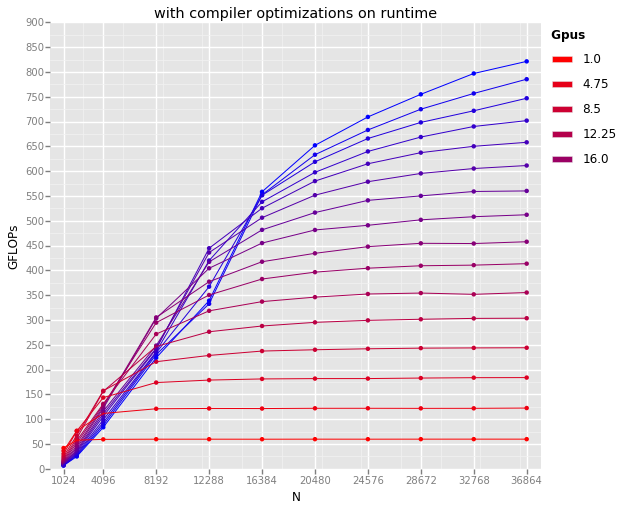

<ggplot: (8741205154845)>

In [28]:
p = ggplot(aes(x="N", y="GFLOPs", color="gpus"), data=df1[(df1.O3 == True) | (df1.gpus == 1)]) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("GFLOPs") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864]) +\
xlim(0, 38000) + ylim(0, 900) + ggtitle("with compiler optimizations on runtime")
p

In [29]:
group1 = df[["O3","gpus","N","linearization_time"]].groupby(["O3", "gpus", "N"]).mean()
group2 = df1[["O3","gpus","N","linearization_time"]].groupby(["O3", "gpus", "N"]).mean()
group2.columns = ["linearization_time_1D"]
group1.columns = ["linearization_time_2D"]
df_tmp = pd.concat([group1, group2], join="outer", axis=1)
df_tmp = df_tmp.reset_index()
df_tmp["linearization_speedup"] = df_tmp[["linearization_time_2D", "linearization_time_1D"]].apply(lambda x: x[0] / x[1], axis=1)
df_tmp.head()

,O3,gpus,N,linearization_time_2D,linearization_time_1D,linearization_speedup
0,False,1,1024,NaN,NaN,NaN
1,False,1,2048,NaN,NaN,NaN
2,False,1,4096,NaN,NaN,NaN
3,False,1,8192,NaN,NaN,NaN
4,False,1,12288,NaN,NaN,NaN


## 1D VS 2D Stencil

Here we evaluate the additional computational time, due to the mandatory linearization of the ISL access maps.

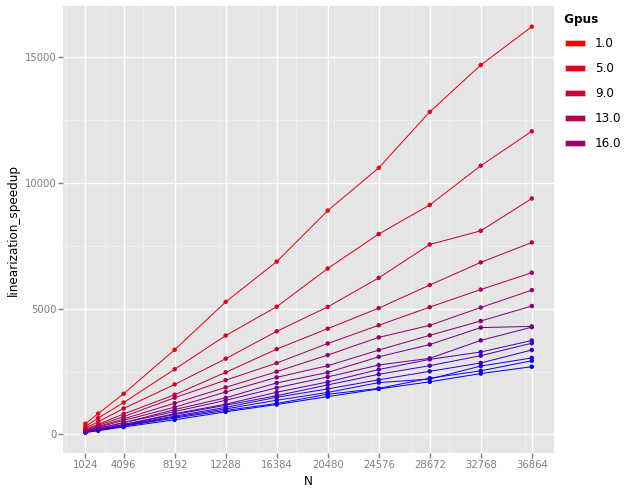

<ggplot: (8741211918605)>

In [30]:
p = ggplot(aes(x="N", y="linearization_speedup", color="gpus"), data=df_tmp) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864]) #+\
#xlim(0, 38000) + ylim(0, 800) + ggtitle("with compiler optimizations on runtime") + ylab("GFLOPs") +\
p

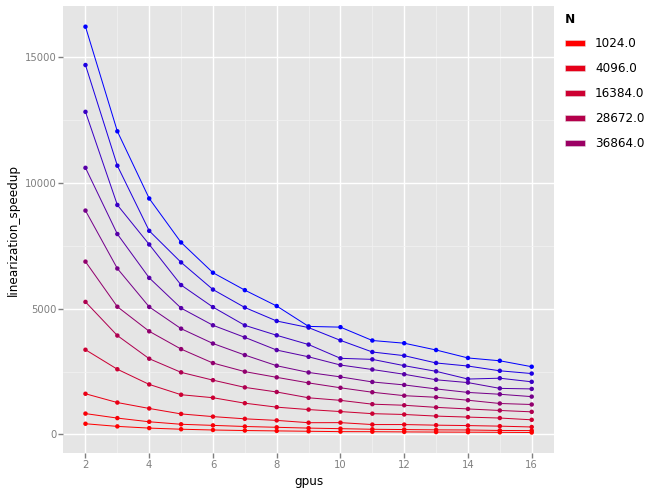

<ggplot: (8741205166829)>

In [31]:
p = ggplot(aes(x="gpus", y="linearization_speedup", color="N"), data=df_tmp) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue")
#scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864]) #+\
#xlim(0, 38000) + ylim(0, 800) + ggtitle("with compiler optimizations on runtime") + ylab("GFLOPs") +\
p

In [32]:
group1 = df[["O3","gpus","N","usr_kernel_time"]].groupby(["O3", "gpus", "N"]).mean()
group2 = df1[["O3","gpus","N","usr_kernel_time"]].groupby(["O3", "gpus", "N"]).mean()
group2.columns = ["usr_kernel_time_1D"]
group1.columns = ["usr_kernel_time_2D"]
df_tmp1 = pd.concat([group1, group2], join="outer", axis=1)
df_tmp1 = df_tmp1.reset_index()
df_tmp1["usr_kernel_time_speedup"] = df_tmp1[["usr_kernel_time_2D", "usr_kernel_time_1D"]].apply(lambda x: x[0] / x[1], axis=1)
df_tmp1.head()

,O3,gpus,N,usr_kernel_time_2D,usr_kernel_time_1D,usr_kernel_time_speedup
0,False,1,1024,0.156810,0.175528,0.893363
1,False,1,2048,0.432228,0.509096,0.849010
2,False,1,4096,1.649292,1.978890,0.833443
3,False,1,8192,6.585502,7.869496,0.836839
4,False,1,12288,15.180620,17.701960,0.857567


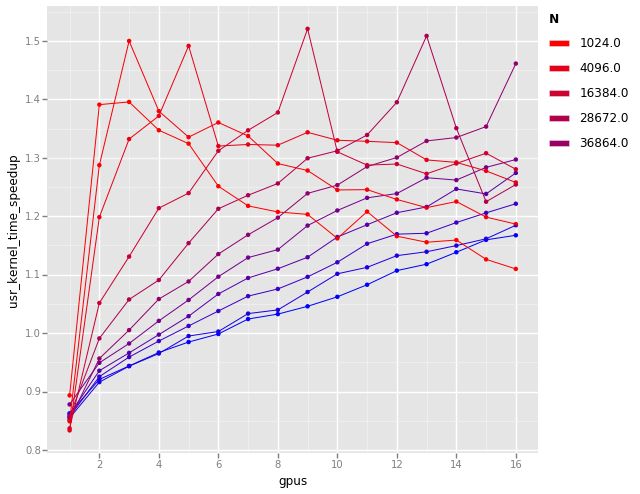

<ggplot: (8741205130809)>

In [33]:
p = ggplot(aes(x="gpus", y="usr_kernel_time_speedup", color="N"), data=df_tmp1) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue")
#scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864]) #+\
#xlim(0, 38000) + ylim(0, 800) + ggtitle("with compiler optimizations on runtime") + ylab("GFLOPs") +\
p

# 25 Point Stencil on Victoria

In [34]:
df25 = pd.read_csv("../victoria_2D_stencil25p_2016-09-19.csv")
df25 = df25.groupby(["gpus", "N"]).mean()
df25 = df25.reset_index()

df25["dep_res_time"] = df25[["dep_res_creation_time", "dep_res_exec_time", "gpus"]].apply(lambda x : 0 if x[2] == 1 else x[0] + x[1], axis=1)
df25["ratio_depres_usrkernel"] = df25[["dep_res_time", "usr_kernel_time"]].apply(lambda x : x[0] / x[1], axis=1)
df25["ratio_depres_exec"] = df25[["dep_res_time", "dep_res_exec_time"]].apply(lambda x : x[1] / x[0], axis=1)
#dfr["kernel_speedup"] = dfr.loc[:,["N", "usr_kernel_time"]].apply(lambda x: dfr[dfr.gpus == 1][dfr.N == x[0]].loc[:,["usr_kernel_time"]].iloc[0,0] / x[1], axis=1)
df25["total_time"] = df25[["usr_htod_time", "usr_kernel_time", "usr_dtoh_time"]].apply(lambda x : x[0] + x[1] + x[2], axis=1)
df25["total_speedup"] = df25.loc[:,["N", "total_time"]].apply(lambda x: df25[df25.gpus == 1][df25.N == x[0]].loc[:,["total_time"]].iloc[0,0] / x[1], axis=1)
df25["kernel-depres"] = df25[["dep_res_time", "usr_kernel_time"]].apply(lambda x : x[1] - x[0], axis=1)
df25["rel_dep_res_creation_time"] = df25[["total_time", "dep_res_creation_time"]].apply(lambda x: x[1]/x[0], axis=1)
df25["calc_increase"] = df25[["N","gpus","kernel-depres"]].apply(lambda x: x[2]\
                             / dfr[(dfr.N == x[0]) & (dfr.gpus == x[1])]["kernel-depres"].iloc[0], axis=1)
df25[df25.gpus == 1].head()

,gpus,N,usr_htod_time,usr_kernel_time,usr_dtoh_time,dep_res_creation_time,dep_res_exec_time,linearization_time,dep_res_time,ratio_depres_usrkernel,ratio_depres_exec,total_time,total_speedup,kernel-depres,rel_dep_res_creation_time,calc_increase
0,1,1024,0.004411,0.510855,0.001508,NaN,NaN,NaN,0,0,NaN,0.516773,1,0.510855,NaN,3.257792
1,1,2048,0.010846,1.616983,0.004979,NaN,NaN,NaN,0,0,NaN,1.632809,1,1.616983,NaN,3.741044
2,1,4096,0.028767,5.971307,0.023843,NaN,NaN,NaN,0,0,NaN,6.023917,1,5.971307,NaN,3.620527
3,1,8192,0.079330,23.343200,0.023580,NaN,NaN,NaN,0,0,NaN,23.446111,1,23.343200,NaN,3.544635
4,1,12288,0.160797,53.715900,0.192412,NaN,NaN,NaN,0,0,NaN,54.069109,1,53.715900,NaN,3.538452


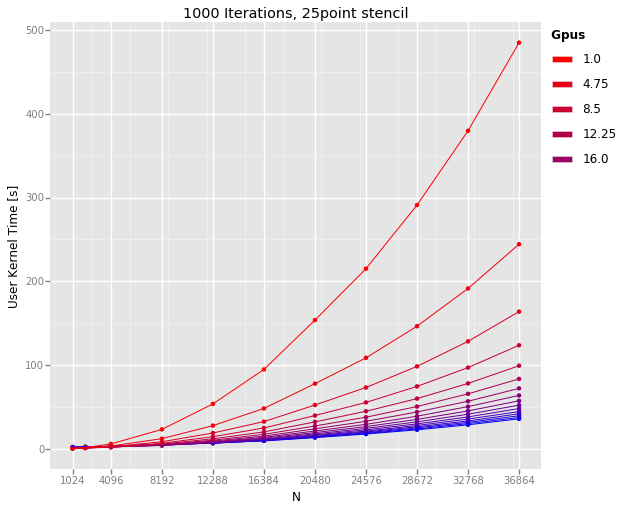

<ggplot: (8741212011209)>

In [35]:
p = ggplot(aes(x="N", y="usr_kernel_time", color="gpus"), data=df25) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("User Kernel Time [s]") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864])+\
ggtitle("1000 Iterations, 25point stencil")
p

Creating two barplots...


Text(0.5,0.98,u'2D Stencil 25p Code ')

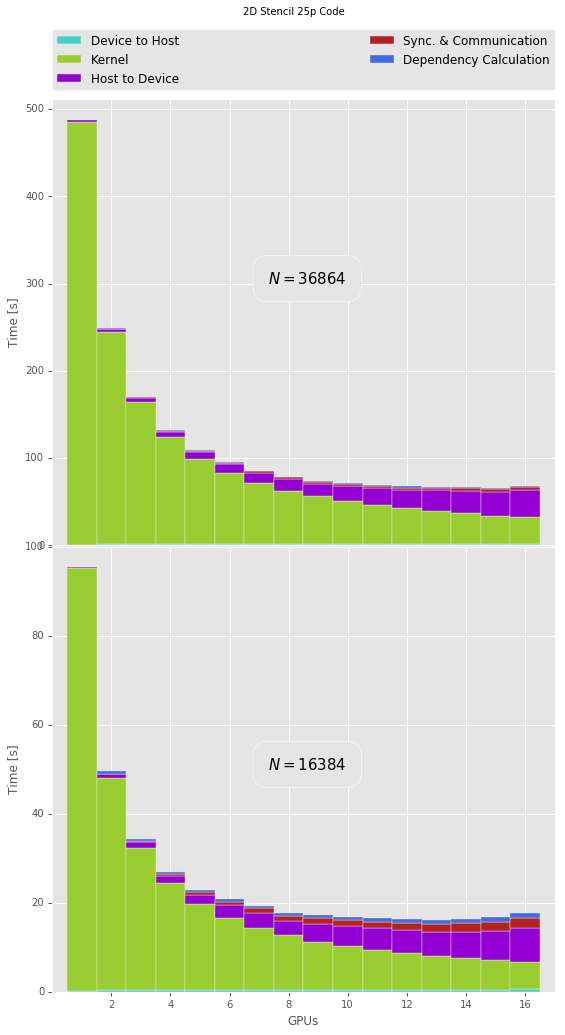

In [36]:
plt.style.use("ggplot")
dummy = df25[df25.N == 36864].loc[:,["gpus","usr_dtoh_time","usr_htod_time", "kernel-depres","dep_res_exec_time", "dep_res_creation_time"]]
dummy.columns = ["GPUs", "Device to Host", "Host to Device", "Kernel", "Communication", "Dependency Calculation"]

sm = ScalarMappable()
sm.set_clim(vmin = 0, vmax = 4)
cmName = "viridis"
sm.set_cmap(cmName)
width = 1
lw = 0.4
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(211)

#colors = ["seagreen", "brown", "darkorange", "indigo"]
colors = ["yellowgreen", "darkviolet", "mediumturquoise", "firebrick", "royalblue"]

##### FIRST BARPLOT
print "Creating two barplots..."

ax.bar(range(1,17), dummy["Device to Host"].values, align="center", width=width,\
      label="Device to Host", linewidth=lw, color=colors[2])
cumu = dummy["Device to Host"].values
ax.bar(range(1,17), dummy["Kernel"].values, width = width, align="center",\
       label="Kernel", linewidth=lw, color=colors[0], bottom=cumu)
cumu += dummy["Kernel"].values
ax.bar(range(1,17), dummy["Host to Device"].values, align="center", width=width,\
       label="Host to Device", bottom = cumu, linewidth=lw, color=colors[1])
cumu += dummy["Host to Device"].values
ax.bar(range(1,17), dummy["Communication"].values, align="center", width=width,\
       label="Sync. & Communication", bottom = cumu, linewidth=lw, color=colors[3])
cumu += dummy["Communication"]
ax.bar(range(1,17), dummy["Dependency Calculation"].values, align="center", width=width,\
       label="Dependency Calculation", bottom = cumu, linewidth=lw, color=colors[4])

ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_ticks_position("left")

ax.set_xlim(0,17)
#ax.set_ylim(0, 175)
ax.set_ylabel("Time [s]")
ax.set_xticks(range(2,17,2))
ax.text(7.3, 300, "$N=36864$", fontsize=15, bbox={"facecolor":ax.get_facecolor(), "edgecolor":"white", "pad":1, "boxstyle":"round"})

#### SECOND BARPLOT

dummy = df25[df25.N == 16384].loc[:,["gpus","usr_dtoh_time","usr_htod_time", "kernel-depres","dep_res_exec_time", "dep_res_creation_time"]]
dummy.columns = ["GPUs", "Device to Host", "Host to Device", "Kernel", "Communication", "Dependency Calculation"]

ax1 = fig.add_subplot(212)

ax1.bar(range(1,17), dummy["Device to Host"].values, align="center", width=width,\
      label="Device to Host", linewidth=lw, color=colors[2])
cumu = dummy["Device to Host"].values
ax1.bar(range(1,17), dummy["Kernel"].values, width = width, align="center",\
       label="Kernel", linewidth=lw, color=colors[0], bottom=cumu)
cumu += dummy["Kernel"].values
ax1.bar(range(1,17), dummy["Host to Device"].values, align="center", width=width,\
       label="Host to Device", bottom = cumu, linewidth=lw, color=colors[1])
cumu += dummy["Host to Device"].values
ax1.bar(range(1,17), dummy["Communication"].values, align="center", width=width,\
       label="Sync. & Communication", bottom = cumu, linewidth=lw, color=colors[3])
cumu += dummy["Communication"]
ax1.bar(range(1,17), dummy["Dependency Calculation"].values, align="center", width=width,\
       label="Dependency Calculation", bottom = cumu, linewidth=lw, color=colors[4])

ax1.get_xaxis().set_ticks_position("bottom")
ax1.get_yaxis().set_ticks_position("left")
ax1.grid(which="minor")
ax1.set_xlim(0,17)
#ax1.set_ylim(0, 40)
#ax1.set_yticks(range(0,40,10))
ax1.set_ylabel("Time [s]")
ax1.set_xlabel("GPUs")
ax1.set_xticks(range(2,17,2))

ax1.text(7.3, 50, "$N=16384$", fontsize=15, bbox={"facecolor":ax1.get_facecolor(),"boxstyle":"round", "edgecolor":"white", "pad":1})

legend = ax.legend(bbox_to_anchor=(0,1.02,1,0.102), loc=3, ncol=2, mode="expand",borderaxespad=0)
legend.get_frame().set_edgecolor("white")

fig.subplots_adjust(hspace=0,top=0.9)
fig.suptitle("2D Stencil 25p Code ")

Text(0.5,1,u'Solid: 25p Stencil, Dashed: 5p Stencil')

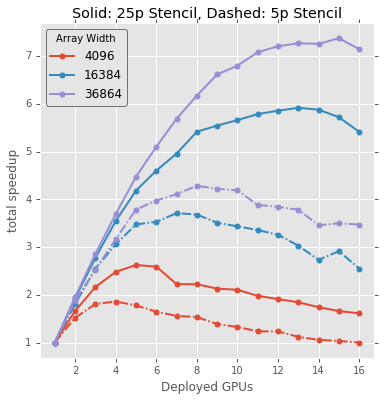

In [37]:
# [1024,4096,8192,12288,16384,20480,24576,28672,32768,36864]
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
lines = []
ms=10
m="."
lw=2
for N in [4096, 16384, 36864]:
    lines.append(ax.plot(df25[df25.N == N]["gpus"].values, df25[df25.N == N]["total_speedup"].values\
                         ,label=N, lw=lw, marker=m, ms=ms))
    ax.plot(dfr[dfr.N == N]["gpus"].values, dfr[dfr.N == N]["total_speedup"].values\
            ,color=lines[-1][0].get_color(), ls="-.", lw=lw, marker=m, ms=ms)
l = ax.legend()
l.set_title("Array Width")
ax.set_xlabel("Deployed GPUs")
ax.set_ylabel("total speedup")
ax.set_title("Solid: 25p Stencil, Dashed: 5p Stencil")

Text(0.5,1,u'Solid: 25p Stencil, Dashed: 5p Stencil')

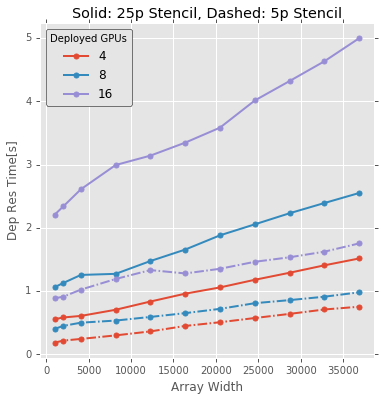

In [38]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
lines = []
ms=10
m="."
lw=2
for gpus in [4, 8, 16]:
    lines.append(ax.plot(df25[df25.gpus == gpus]["N"].values, df25[df25.gpus == gpus]["dep_res_time"].values\
                         ,label=gpus, lw=lw, marker=m, ms=ms))
    ax.plot(dfr[dfr.gpus == gpus]["N"].values, dfr[dfr.gpus == gpus]["dep_res_time"].values\
            ,color=lines[-1][0].get_color(), ls="-.", lw=lw, marker=m, ms=ms)
l = ax.legend()
l.set_title("Deployed GPUs")
ax.set_xlabel("Array Width")
ax.set_ylabel("Dep Res Time[s]")
ax.set_title("Solid: 25p Stencil, Dashed: 5p Stencil")

Text(0.5,1,u'Solid: 25p Stencil, Dashed: 5p Stencil')

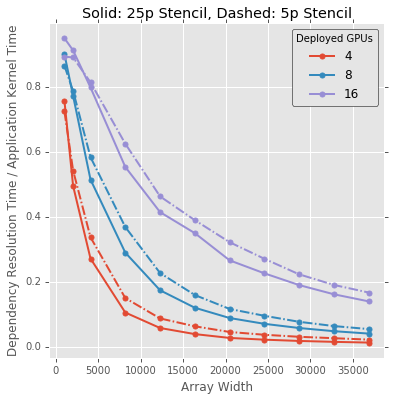

In [39]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
lines = []
ms=10
m="."
lw=2
key="ratio_depres_usrkernel"
for gpus in [4, 8, 16]:
    lines.append(ax.plot(df25[df25.gpus == gpus]["N"].values, df25[df25.gpus == gpus][key].values\
                         ,label=gpus, lw=lw, marker=m, ms=ms))
    ax.plot(dfr[dfr.gpus == gpus]["N"].values, dfr[dfr.gpus == gpus][key].values\
            ,color=lines[-1][0].get_color(), ls="-.", lw=lw, marker=m, ms=ms)
l = ax.legend()
l.set_title("Deployed GPUs")
ax.set_xlabel("Array Width")
ax.set_ylabel("Dependency Resolution Time / Application Kernel Time")
ax.set_title("Solid: 25p Stencil, Dashed: 5p Stencil")

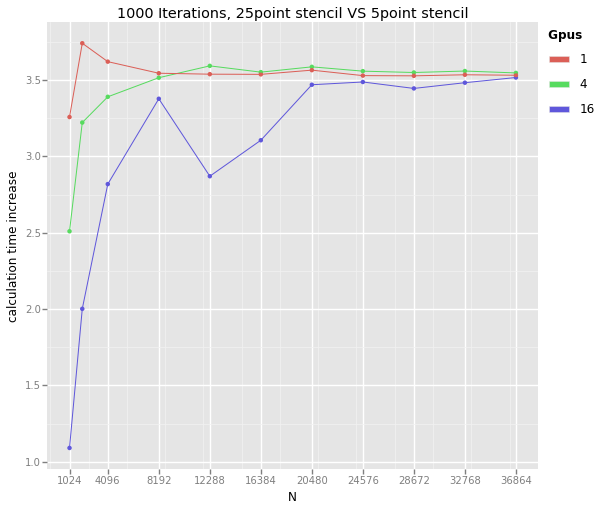

<ggplot: (8741211979557)>

In [40]:
p = ggplot(aes(x="N", y="calc_increase", color="gpus"), data=df25[(df25.gpus == 1) | (df25.gpus == 4) | (df25.gpus == 16)] ) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("calculation time increase") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864])+\
ggtitle("1000 Iterations, 25point stencil VS 5point stencil")
p

# With Dominik's Memcpy Lib on 5p Stencil

In [44]:
dummy = dfr[["gpus", "N", "usr_htod_time"]]
dfdom = pd.read_csv("../victoria_2D_stencil5p_domlib_2016-09-20.csv")
dfdom = dfdom.groupby(["gpus", "N"]).mean()
dfdom = dfdom.reset_index()[["gpus", "N", "usr_htod_time"]]
dfdom["speedup"] = dfdom.apply(lambda x: dfr[(dfr.N == x[1]) & (dfr.gpus == x[0])]["usr_htod_time"].iloc[0] / x[2], axis=1)
dfdom.head()

,gpus,N,usr_htod_time,speedup
0,2,1024,0.004124,0.753123
1,2,2048,0.013137,0.979100
2,2,4096,0.042677,1.010651
3,2,8192,0.114099,1.506119
4,2,12288,0.230146,2.160303


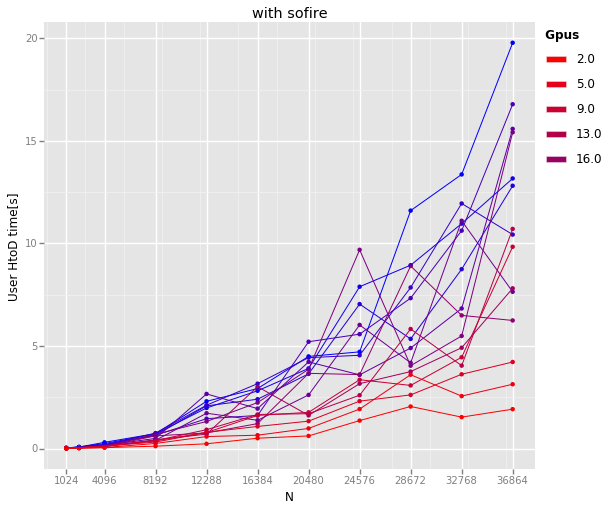

<ggplot: (8741205021949)>

In [48]:
p = ggplot(aes(x="N", y="usr_htod_time", color="gpus"), data=dfdom) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("User HtoD time[s]") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864])+\
ggtitle("with sofire")
p

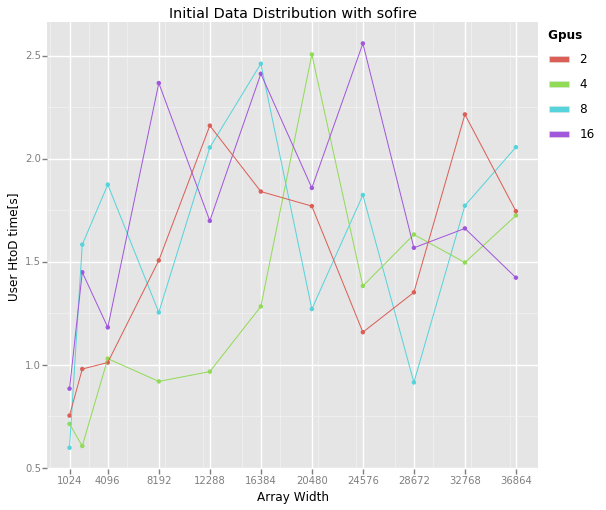

<ggplot: (8741204840393)>

In [50]:
p = ggplot(aes(x="N", y="speedup", color="gpus"), data=dfdom[(dfdom.gpus == 2) | (dfdom.gpus == 4) | (dfdom.gpus == 8) | (dfdom.gpus == 16)]) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("User HtoD time[s]") + xlab("Array Width") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672,32768,36864])+\
ggtitle("Initial Data Distribution with sofire")
p